# Predicting Flight Arrival Delays
## By Nick Palacio

### Constants

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import tree

In [3]:
flightDataFile = './Flight Delays Data.csv'
weatherDataFile = './Weather Data.csv'

### Load Data

In [4]:
flightData = pd.read_csv(flightDataFile)
flightData

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0.0,0.0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0.0,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0.0,0.0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1.0,0.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0.0,0.0
5,2013,4,19,5,DL,10397,15016,1726,-1.0,0.0,1818,-19.0,0.0,0.0
6,2013,4,19,5,DL,15016,10397,1900,0.0,0.0,2133,-1.0,0.0,0.0
7,2013,4,19,5,DL,10397,14869,2145,15.0,1.0,2356,24.0,1.0,0.0
8,2013,4,19,5,DL,10397,10423,2157,33.0,1.0,2333,34.0,1.0,0.0
9,2013,4,19,5,DL,11278,10397,1900,323.0,1.0,2055,322.0,1.0,0.0


### Clean Data

#### Missing Data

In [5]:
utils.FillInMissingNumericValues(flightData,'DepDelay',0)
utils.FillInMissingNumericValues(flightData,'ArrDelay',0)

Filled in 27444 missing values for DepDelay
Filled in 29033 missing values for ArrDelay


#### Duplicate Rows

In [6]:
utils.DropDuplicates(flightData,['Year','Month','DayofMonth','Carrier','OriginAirportID','DestAirportID','CRSDepTime','CRSArrTime'])

Deleted 21 duplicate rows


#### Filter Columns

In [7]:
filteredFlightData = utils.FilterColumns(flightData, ['Year','Month','DayofMonth','DayOfWeek','Carrier','OriginAirportID','DestAirportID','CRSDepTime','DepDelay'])
filteredFlightData

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay
0,2013,4,19,5,DL,11433,13303,837,-3.0
1,2013,4,19,5,DL,14869,12478,1705,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0
3,2013,4,19,5,DL,15016,11433,1630,28.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0
5,2013,4,19,5,DL,10397,15016,1726,-1.0
6,2013,4,19,5,DL,15016,10397,1900,0.0
7,2013,4,19,5,DL,10397,14869,2145,15.0
8,2013,4,19,5,DL,10397,10423,2157,33.0
9,2013,4,19,5,DL,11278,10397,1900,323.0


#### Handle Categorical Data

In [8]:
pristineFlightData = pd.get_dummies(filteredFlightData,columns=['Carrier','OriginAirportID','DestAirportID'])

### Analyze Features

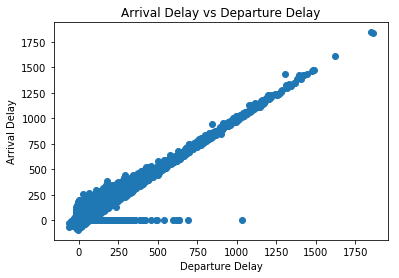

In [9]:
arrDelayData = flightData['ArrDelay']
depDelayData = flightData['DepDelay']
plt.scatter(depDelayData, arrDelayData)
plt.xlabel('Departure Delay')
plt.ylabel('Arrival Delay')
plt.title('Arrival Delay vs Departure Delay')
plt.show()

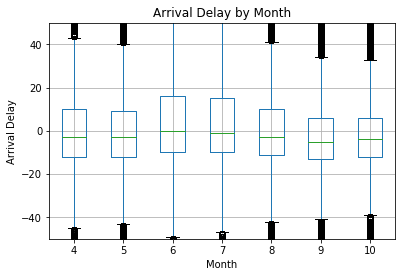

In [10]:
ax = flightData.boxplot('ArrDelay',by='Month',return_type=None)
ax.set_ylim(-50,50)
plt.axes(ax)
plt.ylabel('Arrival Delay')
plt.xlabel('Month')
plt.title('Arrival Delay by Month')
plt.suptitle('')
plt.show()

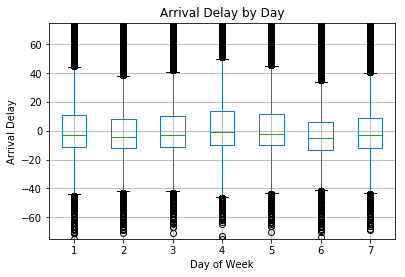

In [11]:
ax = flightData.boxplot('ArrDelay',by='DayOfWeek',return_type=None)
ax.set_ylim(-75,75)
plt.axes(ax)
plt.ylabel('Arrival Delay')
plt.xlabel('Day of Week')
plt.title('Arrival Delay by Day')
plt.suptitle('')
plt.show()

### Run Algorithms

In [12]:
mask = np.random.rand(len(pristineFlightData)) < .7
trainingDataX = pristineFlightData[mask]
testingDataX = pristineFlightData[~mask]
labelData = flightData.filter(items=['ArrDelay'])
trainingLabelData = labelData[mask]
testingLabelData = labelData[~mask]

In [13]:
comparisonDict = {
    'MeanAbsErr': [],
    'MeanSquErr': [],
    'RootMeanSquErr': []
}

#### Linear Regression

In [14]:
linRegrModel = LinearRegression()
linRegrModel.fit(trainingDataX,trainingLabelData)
predictedLRLabelData = linRegrModel.predict(testingDataX)

In [40]:
comparisonDict = utils.UpdateComparisonDict(comparisonDict, testingLabelData, predictedLRLabelData)
comparisonDict

{'MeanAbsErr': [8.800951673114545, 11.903043752175597],
 'MeanSquErr': [167.57923859120947, 307.4106604867454],
 'RootMeanSquErr': [12.945239997435717, 17.533130367585404]}

#### Decision Tree Regression

In [16]:
dtModel = tree.DecisionTreeRegressor()
dtModel.fit(trainingDataX,trainingLabelData)
predictedDTLabelData = dtModel.predict(testingDataX)

In [17]:
comparisonDict = utils.UpdateComparisonDict(comparisonDict, testingLabelData, predictedDTLabelData)

### Comparison of Algorithms

In [18]:
algorithms = ('LR', 'DT')
y_pos = np.arange(len(algorithms))

Text(0.5,1,'MAE by Algorithm')

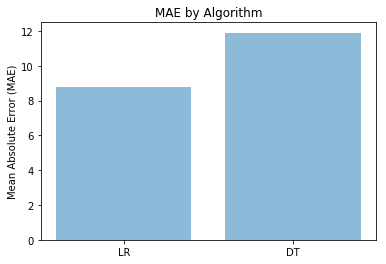

In [19]:
plt.bar(y_pos, comparisonDict['MeanAbsErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE by Algorithm')

Text(0.5,1,'MSE by Algorithm')

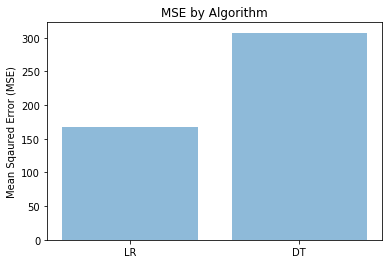

In [20]:
plt.bar(y_pos, comparisonDict['MeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Sqaured Error (MSE)')
plt.title('MSE by Algorithm')

Text(0.5,1,'RMSE by Algorithm')

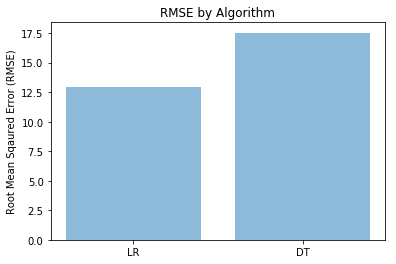

In [21]:
plt.bar(y_pos, comparisonDict['RootMeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Root Mean Sqaured Error (RMSE)')
plt.title('RMSE by Algorithm')

### Introduce Weather Dataset

In [22]:
weatherData = pd.read_csv(weatherDataFile)
colInfoDictArr = [
    {'name': 'Visibility','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'DryBulbCelsius','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'WetBulbCelsius','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'DewPointCelsius','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'RelativeHumidity','valuesToHandle': ['M'],'defaultValue': 0},
    {'name': 'WindSpeed','valuesToHandle': ['M','  '],'defaultValue': 0},
    {'name': 'StationPressure','valuesToHandle': ['M'],'defaultValue': 0}
]
processedWeatherData = utils.ConvertColumnsToNumeric(weatherData, colInfoDictArr)
processedWeatherData

C:\Users\Nick\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AirportID,Year,Month,Day,Time,TimeZone,SkyCondition,Visibility,WeatherType,DryBulbFarenheit,...,WindSpeed,WindDirection,ValueForWindCharacter,StationPressure,PressureTendency,PressureChange,SeaLevelPressure,RecordType,HourlyPrecip,Altimeter
0,14843,2013,4,1,56,-4,FEW018 SCT044 BKN070,10.0,-RA,76,...,13.0,080,,30.06,,,30.06,AA,T,30.07
1,14843,2013,4,1,156,-4,FEW037 SCT070,10.0,,76,...,10.0,090,,30.05,6,017,30.05,AA,,30.06
2,14843,2013,4,1,256,-4,FEW037 SCT070,10.0,,76,...,9.0,100,,30.03,,,30.03,AA,,30.04
3,14843,2013,4,1,356,-4,FEW025 SCT070,10.0,,76,...,9.0,100,,30.02,,,30.03,AA,,30.03
4,14843,2013,4,1,456,-4,FEW025,10.0,,76,...,7.0,110,,30.03,5,004,30.04,AA,,30.04
5,14843,2013,4,1,556,-4,FEW025 SCT080,10.0,,76,...,7.0,100,,30.04,,,30.05,AA,,30.05
6,14843,2013,4,1,656,-4,FEW028 BKN080,10.0,,77,...,9.0,110,,30.07,,,30.07,AA,,30.08
7,14843,2013,4,1,756,-4,FEW028 BKN080,10.0,,79,...,13.0,100,,30.09,3,020,30.10,AA,,30.10
8,14843,2013,4,1,856,-4,FEW030 BKN080,10.0,,82,...,14.0,100,21,30.11,,,30.11,AA,,30.12
9,14843,2013,4,1,956,-4,SCT035 BKN090,10.0,,83,...,16.0,090,23,30.11,,,30.12,AA,,30.12


In [23]:
filteredFlightData['CRSDepHour'] = flightData.apply(lambda row: utils.CalculateFlightDataHour(row),axis=1)
processedWeatherData = utils.UpdateWeatherDataTimeFields(weatherData)

#### Filter Columns

In [24]:
processedWeatherData = utils.FilterColumns(processedWeatherData, ['AirportID','Year','Month','Day','Time','Hour','TimeZone','Visibility','DryBulbCelsius','WetBulbCelsius','DewPointCelsius','RelativeHumidity','WindSpeed','StationPressure'])
processedWeatherData

,AirportID,Year,Month,Day,Time,Hour,TimeZone,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure
0,14843,2013,3,31,56,20,-4,10.0,24.4,23.3,22.8,90.0,13.0,30.06
1,14843,2013,3,31,156,21,-4,10.0,24.4,22.5,21.7,85.0,10.0,30.05
2,14843,2013,3,31,256,22,-4,10.0,24.4,22.5,21.7,85.0,9.0,30.03
3,14843,2013,3,31,356,23,-4,10.0,24.4,22.2,21.1,82.0,9.0,30.02
4,14843,2013,4,1,456,0,-4,10.0,24.4,22.2,21.1,82.0,7.0,30.03
5,14843,2013,4,1,556,1,-4,10.0,24.4,21.8,20.6,79.0,7.0,30.04
6,14843,2013,4,1,656,2,-4,10.0,25.0,21.7,20.0,74.0,9.0,30.07
7,14843,2013,4,1,756,3,-4,10.0,26.1,22.4,20.6,72.0,13.0,30.09
8,14843,2013,4,1,856,4,-4,10.0,27.8,22.9,20.6,65.0,14.0,30.11
9,14843,2013,4,1,956,5,-4,10.0,28.3,23.0,20.6,63.0,16.0,30.11


#### Drop Duplicate Weather Records

In [25]:
utils.DropDuplicates(processedWeatherData, ['AirportID','Year','Month','Day','Hour'])

Deleted 67763 duplicate rows


#### Join with Weather Dataset

In [26]:
mergedData = filteredFlightData.merge(processedWeatherData,how='left', left_on=['OriginAirportID','Year','Month','DayofMonth','CRSDepHour'], right_on=['AirportID','Year','Month','Day','Hour'])
mergedData
# mergedData.columns

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSDepHour,...,Time,Hour,TimeZone,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure
0,2013,4,19,5,DL,11433,13303,837,-3.0,8,...,1353.0,8.0,-5.0,10.0,6.1,3.1,-1.1,60.0,34.0,28.89
1,2013,4,19,5,DL,14869,12478,1705,0.0,17,...,53.0,17.0,-7.0,10.0,7.8,6.6,5.6,86.0,0.0,25.71
2,2013,4,19,5,DL,14057,14869,600,-4.0,6,...,1453.0,6.0,-8.0,10.0,13.9,11.5,9.4,75.0,9.0,30.09
3,2013,4,19,5,DL,15016,11433,1630,28.0,16,...,2251.0,16.0,-6.0,10.0,5.6,1.8,-3.9,51.0,7.0,29.31
4,2013,4,19,5,DL,11193,12892,1615,-6.0,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013,4,19,5,DL,10397,15016,1726,-1.0,17,...,2252.0,17.0,-5.0,10.0,7.8,5.5,2.8,71.0,10.0,28.95
6,2013,4,19,5,DL,15016,10397,1900,0.0,19,...,151.0,19.0,-6.0,10.0,3.9,1.2,-2.8,62.0,6.0,29.35
7,2013,4,19,5,DL,10397,14869,2145,15.0,21,...,252.0,21.0,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
8,2013,4,19,5,DL,10397,10423,2157,33.0,21,...,252.0,21.0,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
9,2013,4,19,5,DL,11278,10397,1900,323.0,19,...,52.0,19.0,-5.0,10.0,11.7,9.4,7.2,74.0,8.0,29.75


#### Drop Columns

In [27]:
columns = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier','OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepDelay','CRSDepHour','ArrDelay','TimeZone','Visibility','DryBulbCelsius','WetBulbCelsius','DewPointCelsius','RelativeHumidity','WindSpeed','StationPressure']
mergedData = utils.FilterColumns(mergedData, columns)
utils.FillInMissingNumericValues(mergedData, 'TimeZone',0)
utils.FillInMissingNumericValues(mergedData, 'Visibility',0)
utils.FillInMissingNumericValues(mergedData, 'DryBulbCelsius',0)
utils.FillInMissingNumericValues(mergedData, 'WetBulbCelsius',0)
utils.FillInMissingNumericValues(mergedData, 'DewPointCelsius',0)
utils.FillInMissingNumericValues(mergedData, 'RelativeHumidity',0)
utils.FillInMissingNumericValues(mergedData, 'WindSpeed',0)
utils.FillInMissingNumericValues(mergedData, 'StationPressure',0)
mergedData

Filled in 287341 missing values for TimeZone
Filled in 287341 missing values for Visibility
Filled in 287341 missing values for DryBulbCelsius
Filled in 287341 missing values for WetBulbCelsius
Filled in 287341 missing values for DewPointCelsius
Filled in 287341 missing values for RelativeHumidity
Filled in 287341 missing values for WindSpeed
Filled in 287341 missing values for StationPressure


,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSDepHour,TimeZone,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure
0,2013,4,19,5,DL,11433,13303,837,-3.0,8,-5.0,10.0,6.1,3.1,-1.1,60.0,34.0,28.89
1,2013,4,19,5,DL,14869,12478,1705,0.0,17,-7.0,10.0,7.8,6.6,5.6,86.0,0.0,25.71
2,2013,4,19,5,DL,14057,14869,600,-4.0,6,-8.0,10.0,13.9,11.5,9.4,75.0,9.0,30.09
3,2013,4,19,5,DL,15016,11433,1630,28.0,16,-6.0,10.0,5.6,1.8,-3.9,51.0,7.0,29.31
4,2013,4,19,5,DL,11193,12892,1615,-6.0,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5,2013,4,19,5,DL,10397,15016,1726,-1.0,17,-5.0,10.0,7.8,5.5,2.8,71.0,10.0,28.95
6,2013,4,19,5,DL,15016,10397,1900,0.0,19,-6.0,10.0,3.9,1.2,-2.8,62.0,6.0,29.35
7,2013,4,19,5,DL,10397,14869,2145,15.0,21,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
8,2013,4,19,5,DL,10397,10423,2157,33.0,21,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
9,2013,4,19,5,DL,11278,10397,1900,323.0,19,-5.0,10.0,11.7,9.4,7.2,74.0,8.0,29.75


#### Handle Categorical Data

In [28]:
mergedData = pd.get_dummies(mergedData,columns=['Carrier','OriginAirportID','DestAirportID','TimeZone'])
mergedData

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSDepHour,Visibility,DryBulbCelsius,WetBulbCelsius,...,DestAirportID_15304,DestAirportID_15376,TimeZone_-10.0,TimeZone_-9.0,TimeZone_-8.0,TimeZone_-7.0,TimeZone_-6.0,TimeZone_-5.0,TimeZone_-4.0,TimeZone_0.0
0,2013,4,19,5,837,-3.0,8,10.0,6.1,3.1,...,0,0,0,0,0,0,0,1,0,0
1,2013,4,19,5,1705,0.0,17,10.0,7.8,6.6,...,0,0,0,0,0,1,0,0,0,0
2,2013,4,19,5,600,-4.0,6,10.0,13.9,11.5,...,0,0,0,0,1,0,0,0,0,0
3,2013,4,19,5,1630,28.0,16,10.0,5.6,1.8,...,0,0,0,0,0,0,1,0,0,0
4,2013,4,19,5,1615,-6.0,16,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
5,2013,4,19,5,1726,-1.0,17,10.0,7.8,5.5,...,0,0,0,0,0,0,0,1,0,0
6,2013,4,19,5,1900,0.0,19,10.0,3.9,1.2,...,0,0,0,0,0,0,1,0,0,0
7,2013,4,19,5,2145,15.0,21,10.0,5.6,3.2,...,0,0,0,0,0,0,0,1,0,0
8,2013,4,19,5,2157,33.0,21,10.0,5.6,3.2,...,0,0,0,0,0,0,0,1,0,0
9,2013,4,19,5,1900,323.0,19,10.0,11.7,9.4,...,0,0,0,0,0,0,0,1,0,0


### Run Algorithms With Weather Data

In [29]:
mask = np.random.rand(len(mergedData)) < .7
trainingDataXWW = mergedData[mask]
testingDataXWW = mergedData[~mask]
labelDataWW = flightData.filter(items=['ArrDelay'])
trainingLabelDataWW = labelDataWW[mask]
testingLabelDataWW = labelDataWW[~mask]

In [30]:
comparisonDictWW = {
    'MeanAbsErr': [],
    'MeanSquErr': [],
    'RootMeanSquErr': []
}

#### Linear Regression With Weather Data

In [31]:
linRegrModelWithWeather = LinearRegression()
linRegrModelWithWeather.fit(trainingDataXWW,trainingLabelDataWW)
predictedLRWWLabelData = linRegrModelWithWeather.predict(testingDataXWW)

In [32]:
comparisonDictWW = utils.UpdateComparisonDict(comparisonDictWW, testingLabelDataWW, predictedLRWWLabelData)
comparisonDictWW

{'MeanAbsErr': [8.793991580460315],
 'MeanSquErr': [167.70942636844381],
 'RootMeanSquErr': [12.95026742459181]}

#### Decision Tree Regression With Weather Data

In [34]:
dtModelWithWeather = tree.DecisionTreeRegressor()
dtModelWithWeather.fit(trainingDataXWW,trainingLabelDataWW)
predictedDTWWLabelData = dtModelWithWeather.predict(testingDataXWW)

In [35]:
comparisonDictWW = utils.UpdateComparisonDict(comparisonDictWW, testingLabelDataWW, predictedDTWWLabelData)
comparisonDictWW

{'MeanAbsErr': [8.793991580460315, 12.07750606268392],
 'MeanSquErr': [167.70942636844381, 310.31398354826166],
 'RootMeanSquErr': [12.95026742459181, 17.615731138623275]}

#### Comparison of Algorithms With Weather Data

In [36]:
algorithms = ('LRWW', 'DTWW')
y_pos = np.arange(len(algorithms))

Text(0.5,1,'MAE by Algorithm')

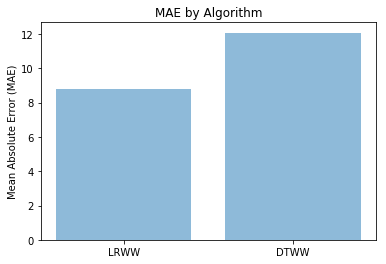

In [37]:
plt.bar(y_pos, comparisonDictWW['MeanAbsErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE by Algorithm')

Text(0.5,1,'MSE by Algorithm')

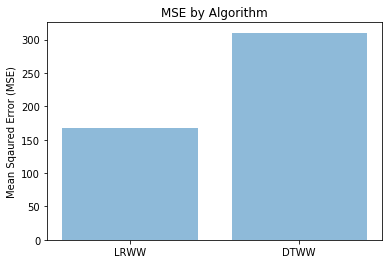

In [38]:
plt.bar(y_pos, comparisonDictWW['MeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Sqaured Error (MSE)')
plt.title('MSE by Algorithm')

Text(0.5,1,'RMSE by Algorithm')

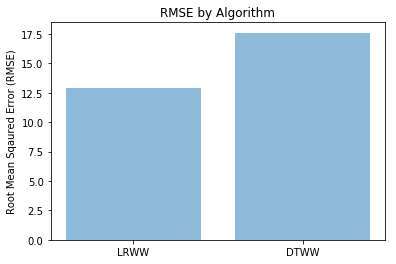

In [39]:
plt.bar(y_pos, comparisonDictWW['RootMeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Root Mean Sqaured Error (RMSE)')
plt.title('RMSE by Algorithm')